In [268]:
import os
import json
from datetime import datetime, timedelta
from herbie import Herbie

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage
import json

from contourpy import ContourGenerator
from typing import Dict, Any, List
import numpy as np


import contourpy

from simplification.cutil import simplify_coords_vw_idx

In [164]:
from weather_access_code import get_latest_hrrr_time
from weather_access_code import contours_to_json

In [183]:
base_path = os.getcwd()
weather_base_path = os.path.join(os.path.join(base_path, 'weather_data'), 'hrrr')
current_time = datetime.utcnow()

hrrr_time_buffer = timedelta(hours=1, minutes=30)

sigma = 0.2

latest_hrrr_time = get_latest_hrrr_time(current_time, hrrr_time_buffer)


In [184]:
hrrr_variables = {':MASSDEN:': ('mdens',
                                'near_surface_smoke',
                                1e-9,
                                np.array([0, 1, 2, 4, 6, 8, 12, 16, 20, 25, 30, 40, 60, 100, 200]))}

In [217]:
from scipy.spatial import distance

def douglas_peucker(points, epsilon):
    # Find the point with the maximum distance
    dmax = 0
    index = 0
    end = len(points) - 1
    for i in range(1, end):
        d = distance.cdist([points[i]], [points[0], points[end]], 'euclidean')
        if d.max() > dmax:
            index = i
            dmax = d.max()

    # If max distance is greater than epsilon, recursively simplify
    if dmax >= epsilon:
        results1 = douglas_peucker(points[:index+1], epsilon)
        results2 = douglas_peucker(points[index:], epsilon)

        # Build the result list
        simplified = np.vstack((results1[:-1], results2))
    else:
        simplified = np.array([points[0], points[end]])

    return simplified


In [285]:
fxx = 0
# for fxx in range(0, 49):
H = Herbie(latest_hrrr_time.strftime('%Y-%m-%d %H:%M:%S'),
               model='hrrr',
               product='sfc',
               fxx=fxx)
latitudes = H.xarray('TMP:2 m above')['latitude'].to_pandas()
longitudes = H.xarray('TMP:2 m above')['longitude'].to_pandas()

key = ':MASSDEN:'
# for key in hrrr_variables.keys():

hrrr_name, description, scaling_factor, levels = hrrr_variables.get(key)
data_array = H.xarray(key)[hrrr_name].to_pandas()
# data_smooth = scipy.ndimage.gaussian_filter(data_array, sigma:= 0.01)
data_smooth_clipped = np.clip(data_array / scaling_factor, levels[0], levels[-1])

longitudes_padded = np.pad(longitudes, 1, mode='edge')
latitudes_padded = np.pad(latitudes, 1, mode='edge')
all_contours, all_levels = [], []
for level in levels[1:]:
    data_smooth_clipped_padded = np.pad(data_smooth_clipped, 1, mode='constant', constant_values=level)
    contour_generator = contourpy.contour_generator(longitudes_padded, latitudes_padded, data_smooth_clipped_padded)
    contours = contour_generator.lines(level)

    simplified_contours = []
    for polygon in contours:
        indices = list(simplify_coords_vw_idx(polygon, epsilon = 0.01))
        indices.append(indices[0])
        simplified_contours.append(polygon[indices])
    all_contours.extend(simplified_contours)
    all_levels.extend([level for _ in range(len(contours))])

geojson = contours_to_json(all_contours, all_levels)


✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2023-Jun-14 18:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


In [286]:
polygon = all_contours[4]


In [287]:
import numpy as np
from contourpy import ContourGenerator
import plotly.graph_objects as go
import matplotlib.pyplot as plt
# Extract ids and levels from the geojson
ids = [feature['id'] for feature in geojson['features']]
levels = [feature['properties']['level'] for feature in geojson['features']]

# Create a Choroplethmapbox trace
fig = go.Figure(go.Choroplethmapbox(
    geojson=geojson,
    locations=ids,  # array of feature ids
    z=levels,  # array of values on z axis (color scale)
    colorscale='Viridis',  # color scale
    marker_line_width=0,  # boundary line width
    marker_opacity=1.,  # transparency
))

fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=3,
                  mapbox_center={"lat": 37.0902, "lon": -95.7129})

fig.show()

TypeError: lines(): incompatible function arguments. The following argument types are supported:
    1. (self: contourpy._contourpy.SerialContourGenerator, arg0: float) -> sequence

Invoked with: <contourpy._contourpy.SerialContourGenerator object at 0x2db2a5af0>, '1'

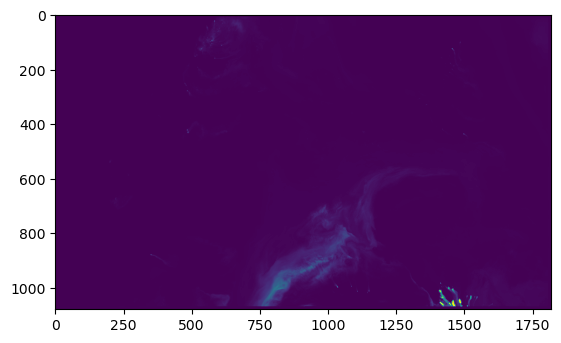

In [242]:








i = 2
plt.imshow(np.pad(data_smooth_clipped, (10), mode='constant', constant_values=np.nan))
plt.imshow(np.pad(data_smooth_clipped, (10), mode='constant', constant_values=levels[i]))

contour_generator = contourpy.contour_generator(longitudes, latitudes, data_smooth_clipped, name='serial', quad_as_tri=True, chunk_size=10000)
# contours = contour_generator.filled(levels[i], levels[-1])
# contour_levels =
contours = contour_generator.lines(levels[i])

# geojson = contours_to_json(contours[0])
fig, ax = plt.subplots()
for contour in contours:
    assert contour[0][0] == contour[-1][0]
    assert contour[0][1] == contour[-1][1]
    ax.plot(*contour.T, color='xkcd:blue')
plt.show()

In [150]:
# len(contours[0])


array([ True,  True])

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2023-Jun-14 00:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws


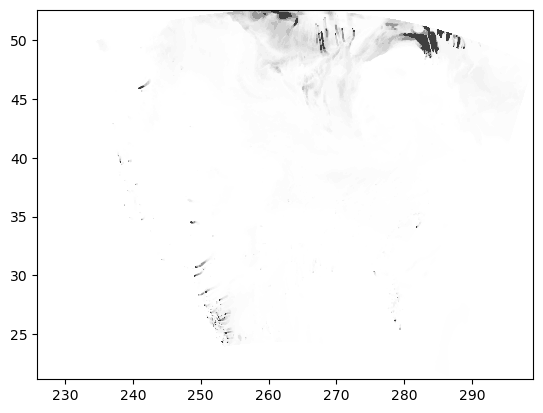

In [86]:
hrrr_variables = {':MASSDEN:': ['mdens', 'near_surface_smoke']}
latest_hrrr_time = get_latest_hrrr_time(current_time - hrrr_time_buffer)

fxx = 0
H = Herbie(latest_hrrr_time.strftime('%Y-%m-%d %H:%M:%S'),
               model='hrrr',
               product='sfc',
               fxx=fxx)

key = ':MASSDEN:'
hrrr_name, description = hrrr_variables.get(key)

data = H.xarray(key)
data_array = data[hrrr_name].to_pandas()

levels = np.array([0, 1, 2, 4, 6, 8, 12, 16, 20, 25, 30, 40, 60, 100, 200])
data_smooth = scipy.ndimage.gaussian_filter(data_array, sigma:= 0.25)
contours = plt.contourf(longitudes, latitudes, np.clip(data_smooth / 1e-9, 1, 200), levels=levels, cmap='gray_r',)
# _ = plt.close()

geojson = contours_to_json(contours)

with open('/Users/aaronspaulding/Documents/PycharmProjects/personal_site/contours.geojson', 'w') as f:
    json.dump(geojson, f)

In [87]:
len(geojson['features'])

2258

In [79]:
# with open('/Users/aaronspaulding/Documents/PycharmProjects/personal_site/contours.geojson', 'r') as file:
#     geojson = json.load(file)
ids = [feature['id'] for feature in geojson['features']]
levels = [feature['properties']['level'] for feature in geojson['features']]
np.unique(ids)

array(['0-0', '0-1', '0-10', ..., '9-97', '9-98', '9-99'], dtype='<U6')

array([  0.,   0.,   0., ..., 100., 100., 100.])

In [37]:
geojson['features'][0]['properties']

{'level': '_nolegend_'}

In [58]:
levels = np.array([0, 1, 2, 4, 6, 8, 12, 16, 20, 25, 30, 40, 60, 100, 200])

# Get the 'viridis' colormap
cmap = plt.get_cmap('Accent')

# Normalize your levels to the range [0, 1]
norm_levels = np.linspace(0, 1, len(levels))



array([  0.        ,   0.92857143,   1.85714286,   3.78571429,
         5.71428571,   7.64285714,  11.57142857,  15.5       ,
        19.42857143,  24.35714286,  29.28571429,  39.21428571,
        59.14285714,  99.07142857, 199.        ])

In [21]:
# import plotly.graph_objects as go
#
#
# with open('contours.geojson', 'r') as file:
#     contours_geojson = json.load(file)
#
# data = pd.DataFrame([{'id': feature['id'], 'level': feature['properties']['level']} for feature in contours_geojson['features']])
#
# fig = go.Figure(go.Choroplethmapbox(geojson=geojson,
#                                     locations=data['id'],
#                                     z=data['level'],
#                                     colorscale="Viridis",
#                                     zmin=0, zmax=12,
#                                     marker_opacity=0.5,
#                                     marker_line_width=0))
#
# fig.update_layout(mapbox_style="carto-positron",
#                   mapbox_zoom=3,
#                   mapbox_center = {"lat": 37.0902, "lon": -95.7129}) # Update this to the desired center
#
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#
# fig.show()

In [44]:
aa = H.xarray(':COLMD:')

In [45]:
# a

In [48]:
# a = a.tc_mdens.to_pandas()

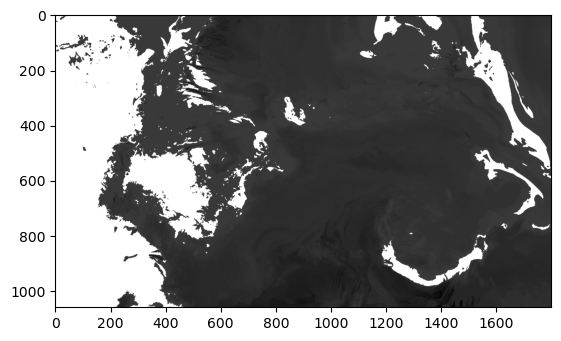

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# plt.imshow(np.log(a), cmap='gray_r')

In [4]:
# https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/zarr_variables.html



base_path = os.getcwd()
weather_base_path = os.path.join(os.path.join(base_path, 'weather_data'), 'hrrr')
current_time = datetime.utcnow()

hrrr_timebuffer = timedelta(hours=1, minutes=30)

status_file_path = os.path.join(base_path, 'status.json')
if os.path.exists(status_file_path):
    with open(status_file_path, 'r') as file:
        status = json.load(file)
else:
    status = {
        'hrrr_last_updated_time_utc': None,
        'hrrr_valid_time_utc': None,
    }



In [5]:
hrrr_variables = {'MASSDEN': 'near_surface_smoke'}
latest_hrrr_time = get_latest_hrrr_time(current_time - hrrr_timebuffer)
H = Herbie(latest_hrrr_time.strftime('%Y-%m-%d %H:%M:%S'),
           model='hrrr',
           product='sfc',
           fxx=0)

data = H.xarray(':TMP:2 m')
latitude_coordinates = data.latitude.to_pandas()
longitude_coordinates = data.longitude.to_pandas()

latitude_coordinates.to_parquet(os.path.join(weather_base_path, 'latitudes.parquet'))
longitude_coordinates.to_parquet(os.path.join(weather_base_path, 'longitude.parquet'))

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2023-Jun-09 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


In [22]:
os.path.join(weather_base_path, 'longitude.parquet')

'/Users/aaronspaulding/Documents/PycharmProjects/live_weather_data/weather_data/hrrr/longitude.parquet'